In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load the dataset
column_names = ["Sex", "Length", "Diameter", "Height", "Whole weight", 
                "Shucked weight", "Viscera weight", "Shell weight", "Rings"]
abalone_data = pd.read_csv("abalone.data.csv", names=column_names)

# Converting 'Rings' to represent age
abalone_data['Age'] = abalone_data['Rings'] + 1.5
abalone_data.drop('Rings', axis=1, inplace=True)

# Check data types for each column
data_types = abalone_data.dtypes

# Check for missing values in the dataset
missing_values = abalone_data.isnull().sum()

# Produce summary statistics for the dataset
summary_statistics = abalone_data.describe(include='all')

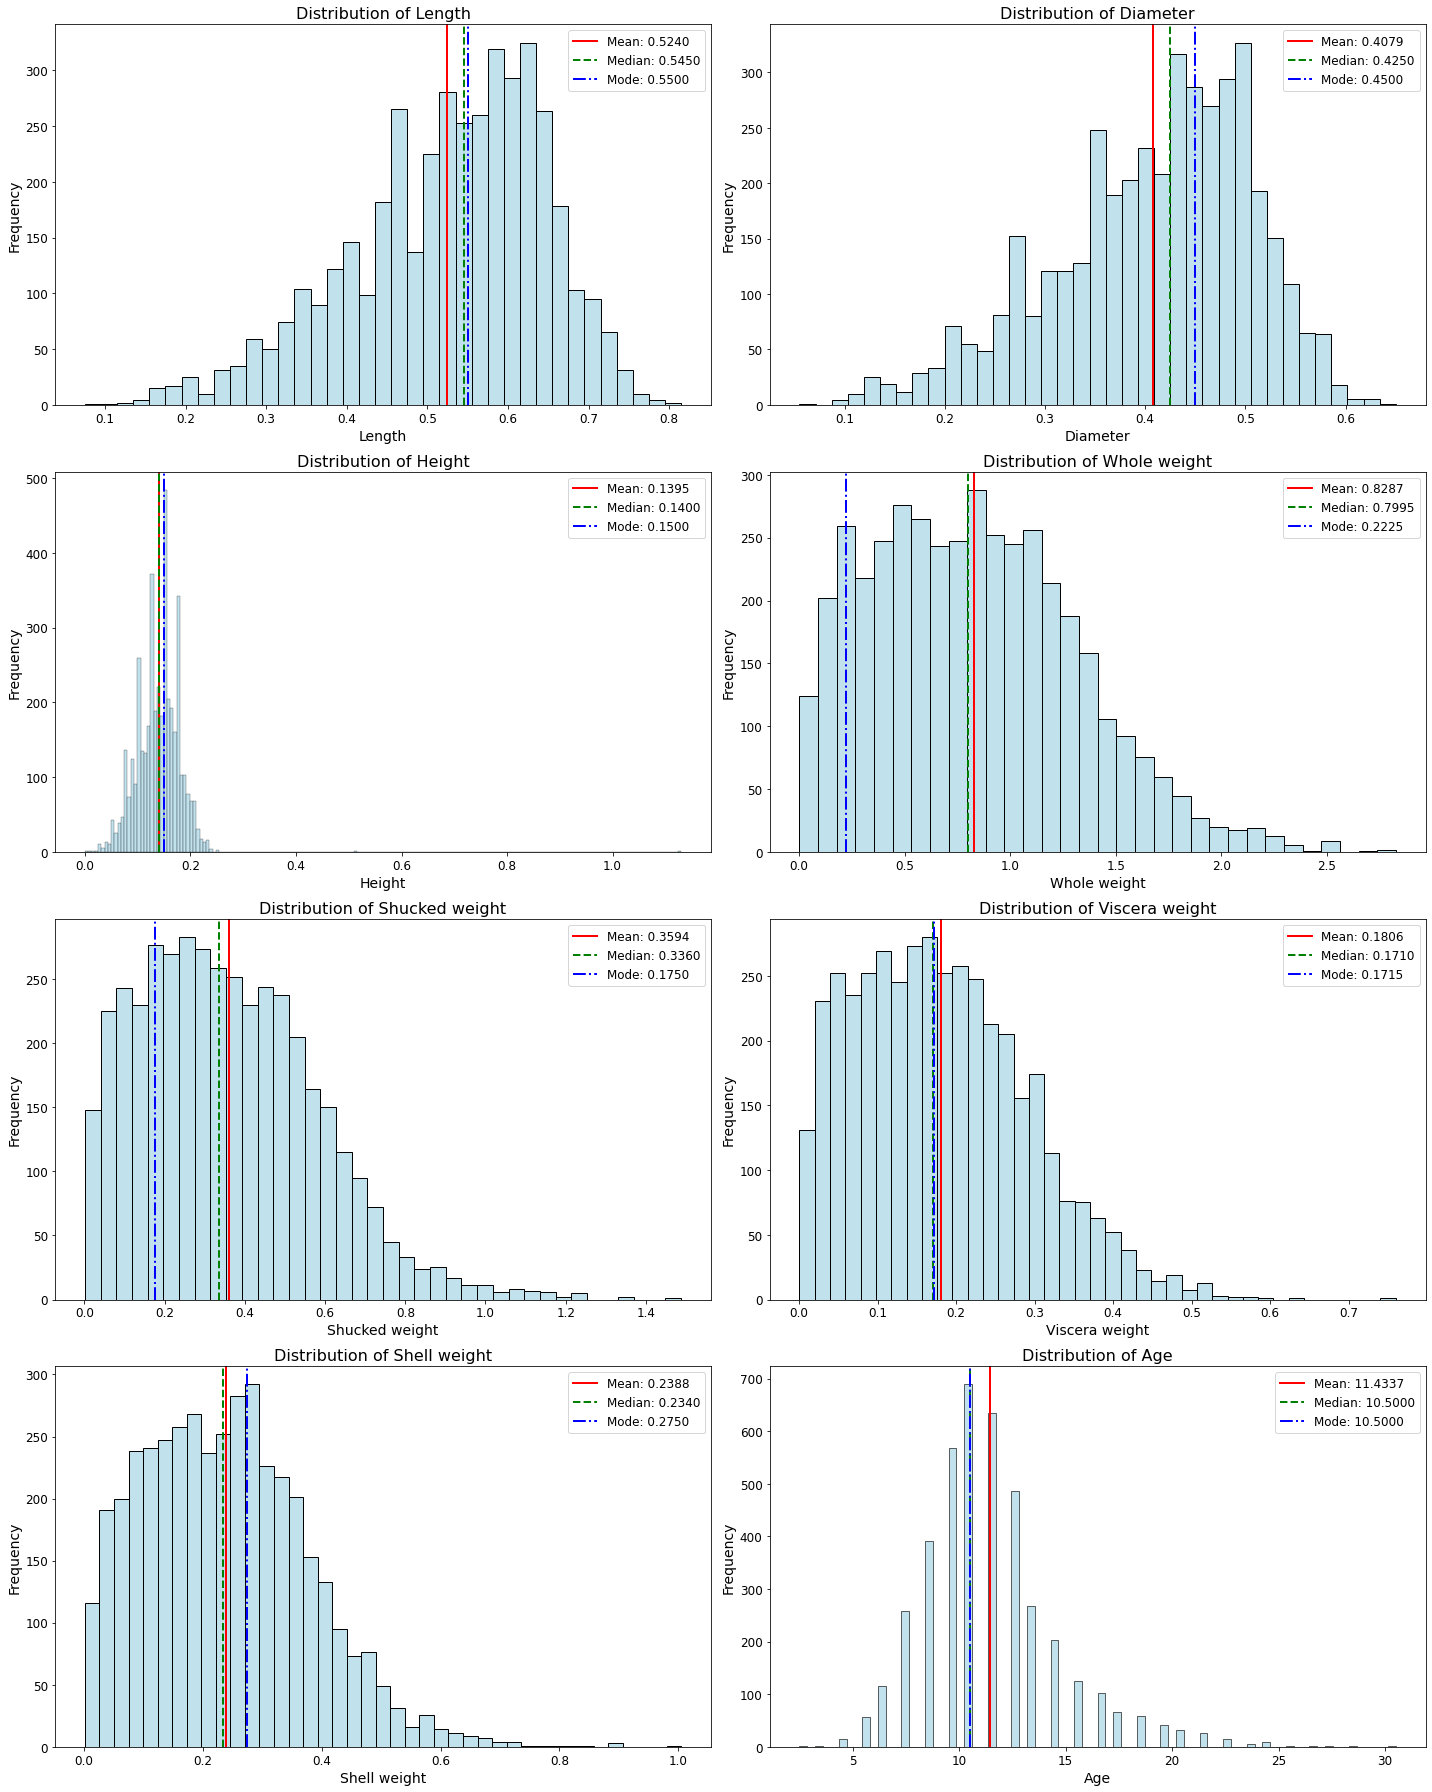

In [3]:
# Set up the figure for larger subplots
fig, ax = plt.subplots(4, 2, figsize=(20, 25))

numerical_attributes = abalone_data.drop(columns="Sex")
# Plotting the distribution for each numerical attribute with mean, median, and mode
for i, attr in enumerate(numerical_attributes):
    row = i // 2
    col = i % 2
    
    # Plotting histogram
    sns.histplot(abalone_data[attr], ax=ax[row, col], color='lightblue')
    
    # Plotting mean with 3 decimal places
    ax[row, col].axvline(abalone_data[attr].mean(), color='red', linestyle='-', linewidth=2, 
                         label=f"Mean: {abalone_data[attr].mean():.4f}")
    
    # Plotting median with 3 decimal places
    ax[row, col].axvline(abalone_data[attr].median(), color='green', linestyle='--', linewidth=2, 
                         label=f"Median: {abalone_data[attr].median():.4f}")
    
    # Plotting mode with 3 decimal places
    mode_value = abalone_data[attr].mode().iloc[0]
    ax[row, col].axvline(mode_value, color='blue', linestyle='-.', linewidth=2, 
                         label=f"Mode: {mode_value:.4f}")
    
    # Setting titles and labels
    ax[row, col].set_title(f"Distribution of {attr}", fontsize=16)
    ax[row, col].set_xlabel(attr, fontsize=14)
    ax[row, col].set_ylabel("Frequency", fontsize=14)
    ax[row, col].tick_params(labelsize=12)
    ax[row, col].legend(fontsize=12)

# Adjust the layout
plt.tight_layout()
plt.show()

### Length and Diameter:

Both are slightly left-skewed.
Majority of abalones have lengths and diameters around 0.550 and 0.450, respectively.

### Height:

Right-skewed distribution.
Most abalones have heights concentrated around 0.140 to 0.150.

### Whole weight, Shucked weight, Viscera weight, and Shell weight:

All these weight attributes are right-skewed.
The majority of abalones have weights on the lower side, with only a few having significantly higher weights. For instance, most abalones have a whole weight below 1.

### Age:

Right-skewed distribution.
Most abalones are younger, with a majority of them are 10.5.

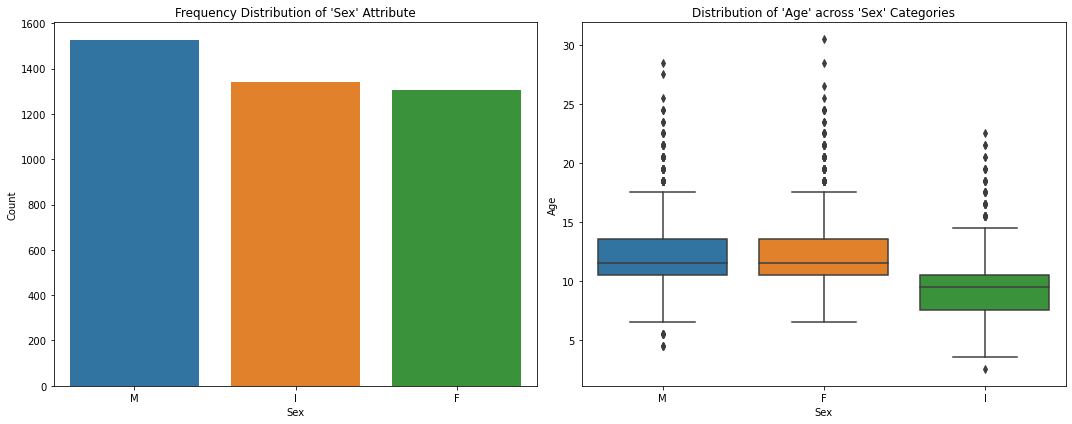

In [4]:
# Set up the figure and axes for side-by-side plots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plotting the frequency distribution for 'Sex'
sns.countplot(data=abalone_data, x="Sex", order=abalone_data["Sex"].value_counts().index, ax=ax[0])
ax[0].set_title("Frequency Distribution of 'Sex' Attribute")
ax[0].set_xlabel("Sex")
ax[0].set_ylabel("Count")

# Boxplot for distribution of 'Age' across 'Sex' categories
sns.boxplot(data=abalone_data, x="Sex", y="Age", ax=ax[1])
ax[1].set_title("Distribution of 'Age' across 'Sex' Categories")
ax[1].set_xlabel("Sex")
ax[1].set_ylabel("Age")

# Adjust the layout
plt.tight_layout()
plt.show()

### Frequency Distribution of 'Sex' Attribute:

Infant (I) abalones dominate the dataset, followed closely by Male (M) and then Female (F) abalones.

### Distribution of 'Age' across 'Sex' Categories:

The median age is quite similar across all three categories.
Male (M) and Female (F) abalones tend to have some outliers with higher age.
Infant (I) abalones, as expected indicating a younger age.

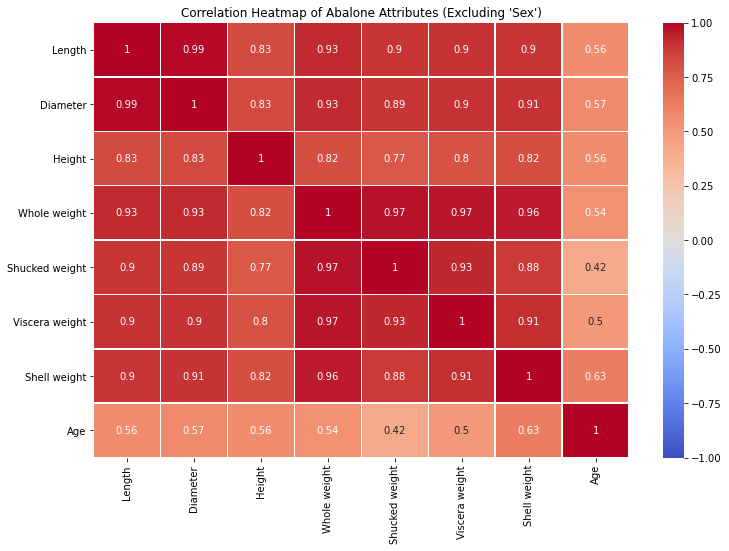

In [5]:
# Leaving out the 'Sex' column and plotting the correlation heatmap for the remaining numerical attributes
numeric_data_without_sex = abalone_data.drop(columns="Sex")

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data_without_sex.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=.5)
plt.title("Correlation Heatmap of Abalone Attributes (Excluding 'Sex')")
plt.show()

### Length, Diameter, and Height:

These size attributes show strong positive correlations with each other.

### Weight Attributes (Whole weight, Shucked weight, Viscera weight, Shell weight):

They are strongly positively correlated with one another and also with the size attributes.

### Age:

Moderately strong positive correlation with Shell weight and other attributes, though not as strong as the correlations among the size and weight attributes.

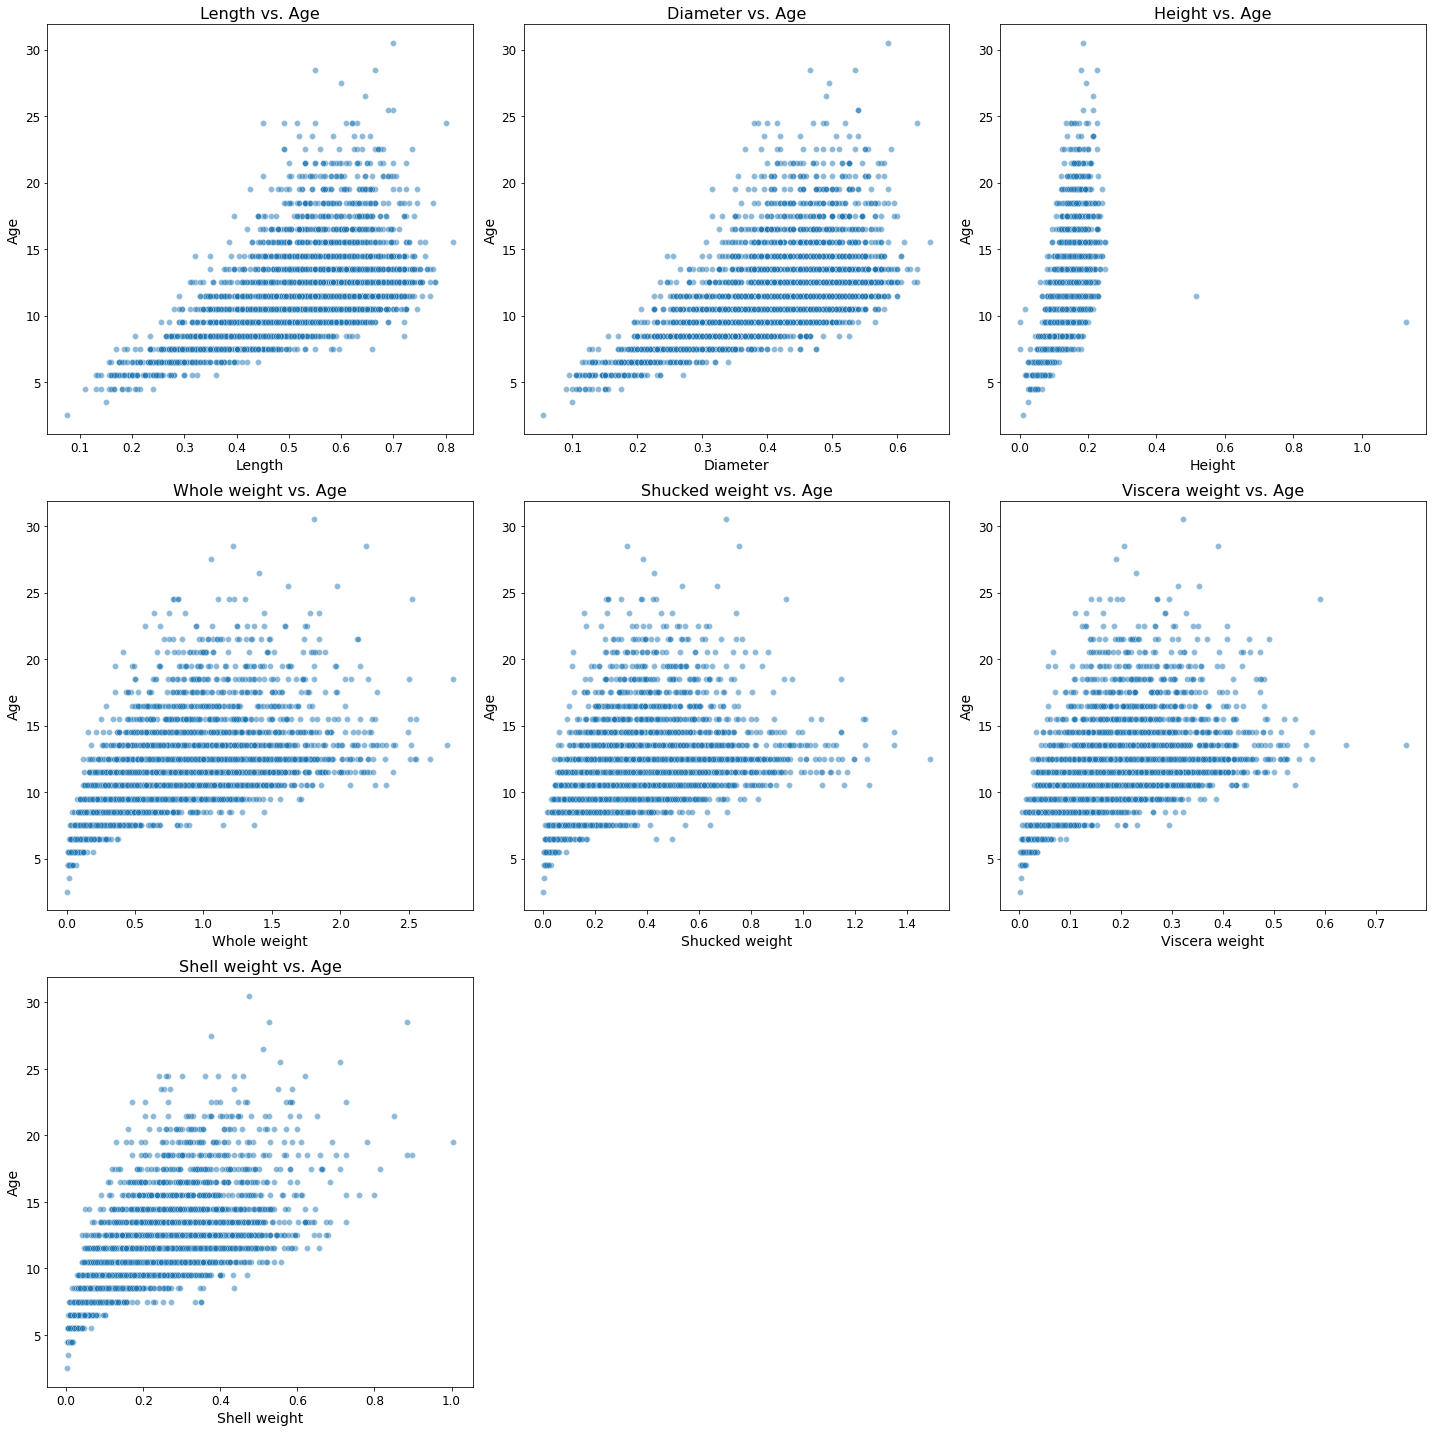

In [6]:
# Set up the figure for scatter plots
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

# Plotting scatter plots for each numerical attribute against the target variable 'Age'
for i, attr in enumerate(numerical_attributes[:-1]):  # Excluding 'Age' from attributes since it's the target
    row = i // 3
    col = i % 3
    sns.scatterplot(data=abalone_data, x=attr, y="Age", ax=ax[row, col], alpha=0.5)
    
    # Setting titles and labels
    ax[row, col].set_title(f"{attr} vs. Age", fontsize=16)
    ax[row, col].set_xlabel(attr, fontsize=14)
    ax[row, col].set_ylabel("Age", fontsize=14)
    ax[row, col].tick_params(labelsize=12)

# Removing the empty plots
for i in range(7, 9):
    fig.delaxes(ax.flatten()[i])

# Adjust the layout
plt.tight_layout()
plt.show()

Features like Length, Diameter, and Shell weight show a clear positive correlation with the age.

The spread in the Weight attributes indicates some level of variance, but the general trend is still positive with age.

There are certain outliers, especially in the Height attribute, that may need further investigation.

### Handling Outliers

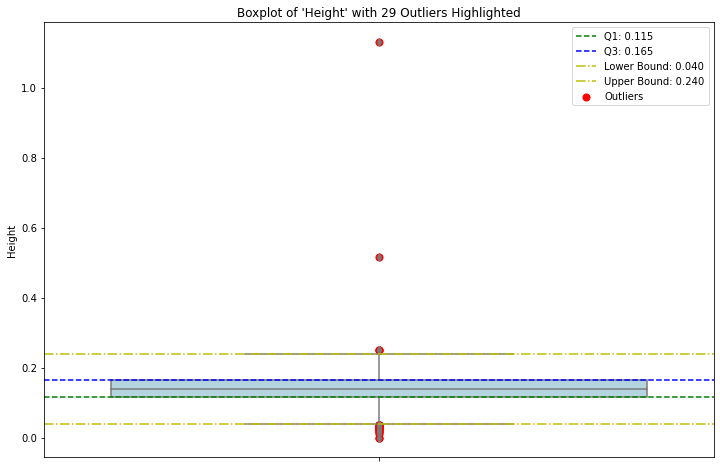

In [7]:
# Calculating the IQR for the 'Height' attribute
Q1 = abalone_data['Height'].quantile(0.25)
Q3 = abalone_data['Height'].quantile(0.75)
IQR = Q3 - Q1

# Determining the lower and upper bounds for potential outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering the data points that fall outside of these bounds
outliers = abalone_data[(abalone_data['Height'] < lower_bound) | (abalone_data['Height'] > upper_bound)]
outliers_count = outliers.shape[0]
#There are total of 29 outliers

# Plotting the detailed boxplot for the 'Height' attribute with the number of outliers added to the plot title
plt.figure(figsize=(12, 8))
sns.boxplot(y=abalone_data['Height'], orient='v', color='lightblue')
plt.scatter(x=[0]*outliers_count, y=outliers['Height'], color='red', s=50, label='Outliers')
plt.axhline(y=Q1, color='g', linestyle='--', label=f'Q1: {Q1:.3f}')
plt.axhline(y=Q3, color='b', linestyle='--', label=f'Q3: {Q3:.3f}')
plt.axhline(y=lower_bound, color='y', linestyle='-.', label=f'Lower Bound: {lower_bound:.3f}')
plt.axhline(y=upper_bound, color='y', linestyle='-.', label=f'Upper Bound: {upper_bound:.3f}')
plt.title(f"Boxplot of 'Height' with {outliers_count} Outliers Highlighted")
plt.ylabel("Height")
plt.legend()
plt.show()

In [8]:
# Capping the outliers in the 'Height' attribute
abalone_data['Height'] = np.where(abalone_data['Height'] < lower_bound, lower_bound, abalone_data['Height'])
abalone_data['Height'] = np.where(abalone_data['Height'] > upper_bound, upper_bound, abalone_data['Height'])

### Feature Engineering

In [9]:
# Creating the 'Volume' feature
abalone_data['Volume'] = abalone_data['Length'] * abalone_data['Diameter'] * abalone_data['Height']

# Creating weight ratios
abalone_data['Shucked_to_Whole'] = abalone_data['Shucked weight'] / abalone_data['Whole weight']
abalone_data['Viscera_to_Whole'] = abalone_data['Viscera weight'] / abalone_data['Whole weight']
abalone_data['Shell_to_Whole'] = abalone_data['Shell weight'] / abalone_data['Whole weight']

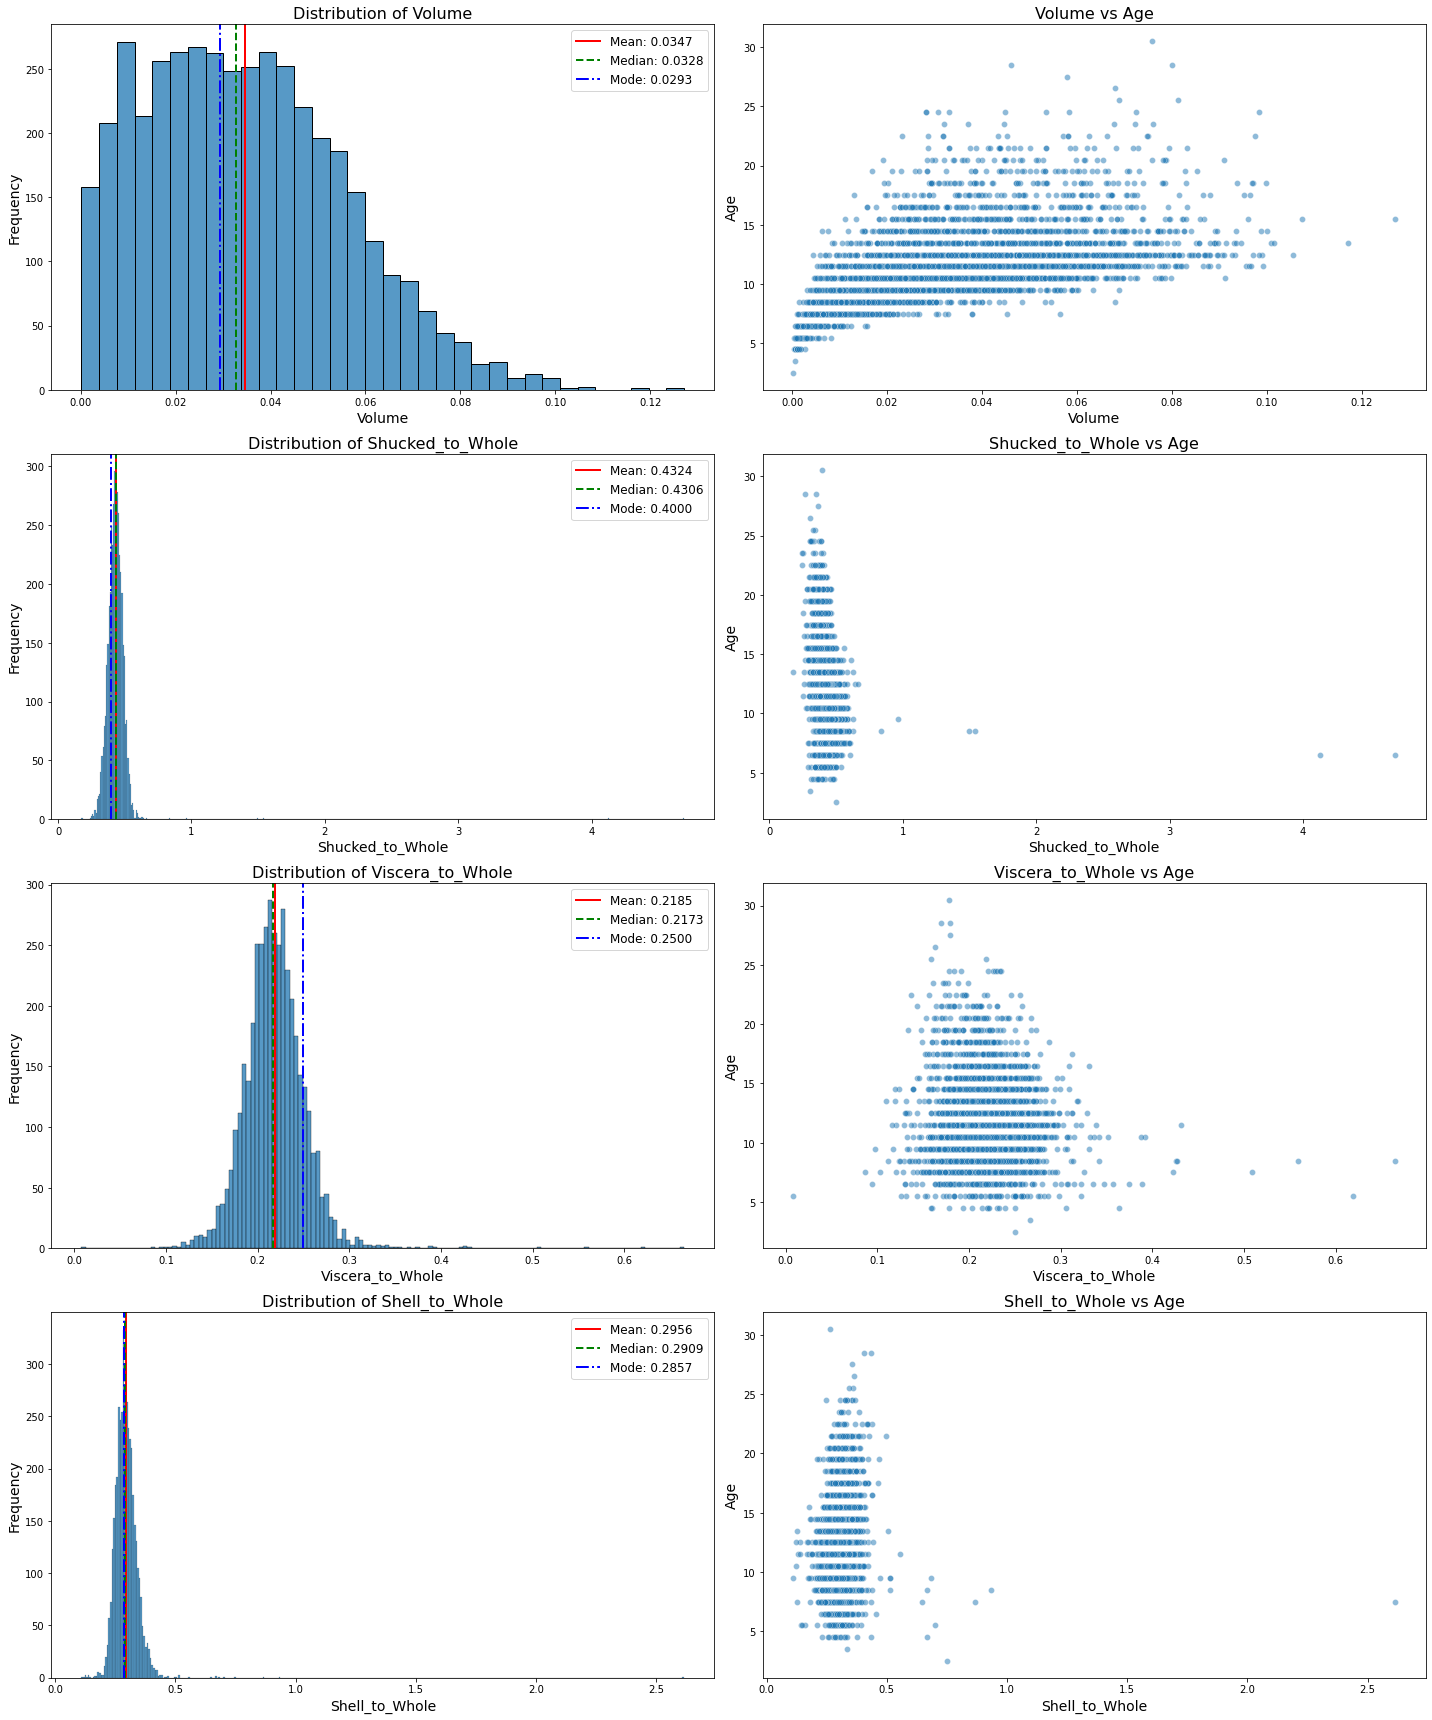

In [10]:
# Plotting the distributions of the new features with mean, median, and mode highlighted

new_features=['Volume','Shucked_to_Whole','Viscera_to_Whole','Shell_to_Whole']

fig, axes = plt.subplots(4, 2, figsize=(20, 24))

for i, feature in enumerate(new_features):
    # Distribution of the new feature
    sns.histplot(abalone_data[feature], ax=axes[i, 0])
    
    # Plotting mean
    axes[i, 0].axvline(abalone_data[feature].mean(), color='red', linestyle='-', linewidth=2, 
                       label=f"Mean: {abalone_data[feature].mean():.4f}")
    
    # Plotting median
    axes[i, 0].axvline(abalone_data[feature].median(), color='green', linestyle='--', linewidth=2, 
                       label=f"Median: {abalone_data[feature].median():.4f}")
    
    # Plotting mode
    mode_value = abalone_data[feature].mode().iloc[0]
    axes[i, 0].axvline(mode_value, color='blue', linestyle='-.', linewidth=2, 
                       label=f"Mode: {mode_value:.4f}")
    
    # Setting titles and labels
    axes[i, 0].set_title(f"Distribution of {feature}", fontsize=16)
    axes[i, 0].set_xlabel(feature, fontsize=14)
    axes[i, 0].set_ylabel('Frequency', fontsize=14)
    axes[i, 0].legend(fontsize=12)
    
    # Relationship of the new feature with the target variable 'Age'
    sns.scatterplot(x=abalone_data[feature], y=abalone_data['Age'], ax=axes[i, 1], alpha=0.5)
    axes[i, 1].set_title(f'{feature} vs Age', fontsize=16)
    axes[i, 1].set_xlabel(feature, fontsize=14)
    axes[i, 1].set_ylabel('Age', fontsize=14)

plt.tight_layout()
plt.show()

## Volume:

Right-skewed. This suggests that there are fewer abalones with larger volumes, but the majority are clustered around a smaller volume size. As the volume increases, age tends to increase. This is consistent with our understanding that larger abalones are typically older.

## Shucked_to_Whole:

Slightly left-skewed. This means that while many abalones have a higher shucked-to-whole weight ratio, there's a notable amount with a lower ratio. There appears to be a slight trend indicating that younger abalones have a higher shucked-to-whole weight ratio.

## Viscera_to_Whole:

Appears to be fairly symmetrical, which suggests a balance in the viscera-to-whole weight ratio across the dataset. Might not have a strong linear relationship with the age of the abalone.

## Shell_to_Whole:

Left-skewed. This indicates that many abalones have a higher shell-to-whole weight ratio, but there's also a significant number with a lower ratio. Ratio increases, age also increases. This could imply that as abalones age, the proportion of their weight that's shell increases, possibly due to the thickening of the shell over time.

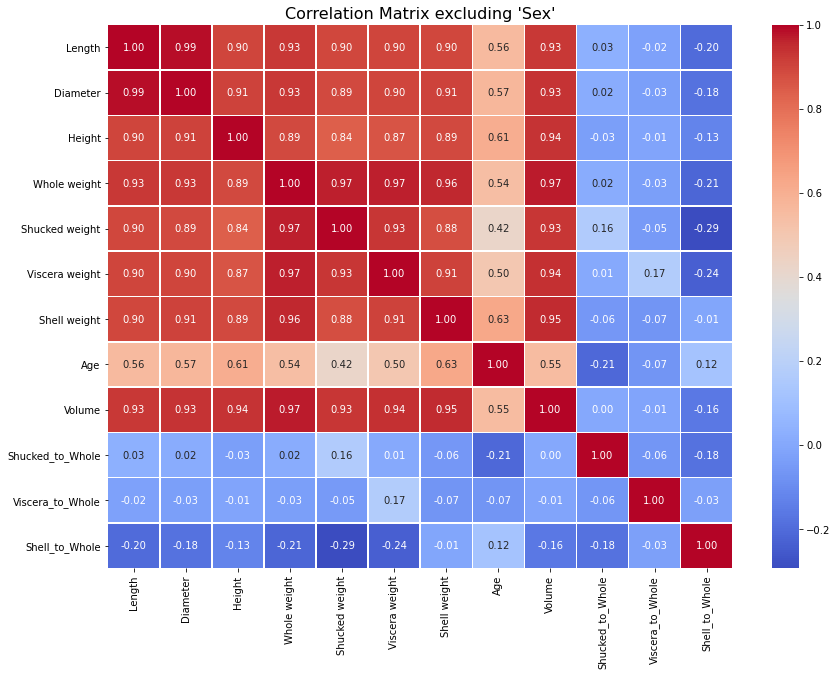

In [11]:
# Generating the correlation matrix excluding the 'Sex' column
correlation_matrix_without_sex = abalone_data.drop(columns=['Sex']).corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_without_sex, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix excluding 'Sex'", fontsize=16)
plt.show()

The newly created feature Volume showcases a positive correlation with age, indicating its potential in predicting the age of abalones.

Weight ratios like Shucked_to_Whole and Shell_to_Whole also demonstrate significant correlations with age.

Inter-feature correlations are evident, especially for derived features and their constituent parts.

In [12]:
# One-hot encoding the 'Sex' column
abalone_data_encoded = pd.get_dummies(abalone_data, columns=['Sex'], drop_first=True)

Sex_I: Represents the "Infant" category. It will be 1 if the abalone is an infant and 0 otherwise.

Sex_M: Represents the "Male" category. It will be 1 if the abalone is male and 0 otherwise.

"Female" category is inferred. Specifically, if both Sex_I and Sex_M are 0, then the abalone is female.

## Feature Selection

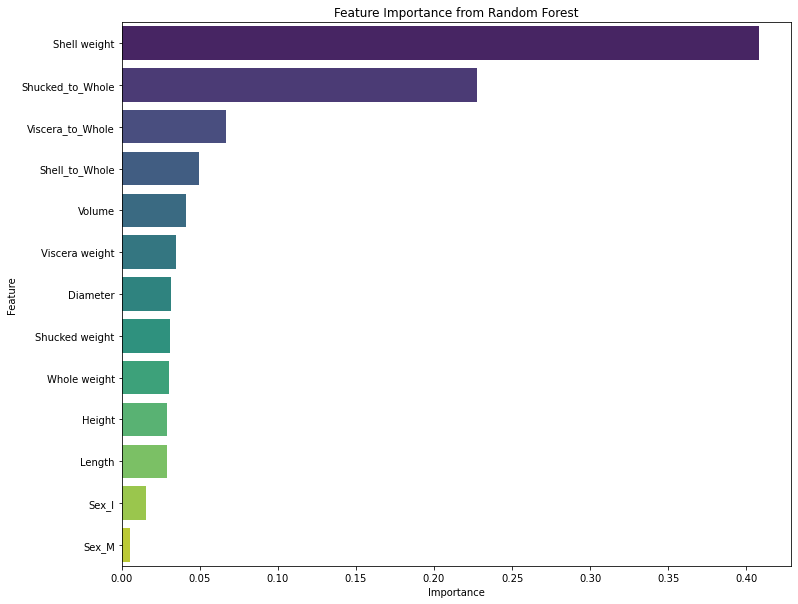

In [13]:
# Feature Importance from Tree-based Models: Initializing the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting the model to our data to compute feature importances
X = abalone_data_encoded.drop("Age", axis=1)  # Independent variables
y = abalone_data_encoded["Age"]  # Target variable
rf.fit(X, y)

# Extracting feature importances
feature_importances = rf.feature_importances_

# Creating a DataFrame for visualization
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sorting the features based on importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## Shell weight:

This emerged as the top predictor for the age of abalone. As abalones age, their shells grow and thicken. The strong correlation between shell growth and age makes this feature paramount in predicting the age.

## Shucked_to_Whole and Viscera_to_Whole:

These are ratios representing the proportion of meat and viscera weight to the whole weight of the abalone, respectively. Their prominence in the ranking suggests that the internal composition of the abalone, represented by these ratios, changes in a manner consistent with aging.

## Shell_to_Whole:

This ratio, indicating the proportion of the shell weight to the whole weight, is another vital predictor. The shell's growth and its relationship to the overall weight of the abalone could be indicative of its age.

## Volume:

This derived feature, representing the overall size or spatial occupancy of the abalone, is significant. In general, larger abalones might be older, but it's important to note that Volume ranks after the above-mentioned features.

## Sex_I and Sex_M:

The gender of the abalone, while having some influence, is not a dominant predictor when compared to the physical measurements and derived ratios. These features rank at the bottom of our importance list.

Other physical measurements like Diameter, Viscera weight, Shucked weight, Whole weight, Length, and Height also play roles in age prediction, though they are of relatively lesser importance compared to the top-ranked features.

## Modelling

In [14]:
# Splitting the data into training and testing sets (80% train, 20% test)
X = abalone_data_encoded.drop("Age", axis=1)
y = abalone_data_encoded["Age"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# Initializing the Baseline Linear Regression model
lr_baseline = LinearRegression()

# Training the model on the training set
lr_baseline.fit(X_train_scaled, y_train)

# Making predictions on the test set
y_pred_baseline = lr_baseline.predict(X_test_scaled)

# Calculating evaluation metrics
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
rmse_baseline = mean_squared_error(y_test, y_pred_baseline, squared=False)
r2_baseline = r2_score(y_test, y_pred_baseline)

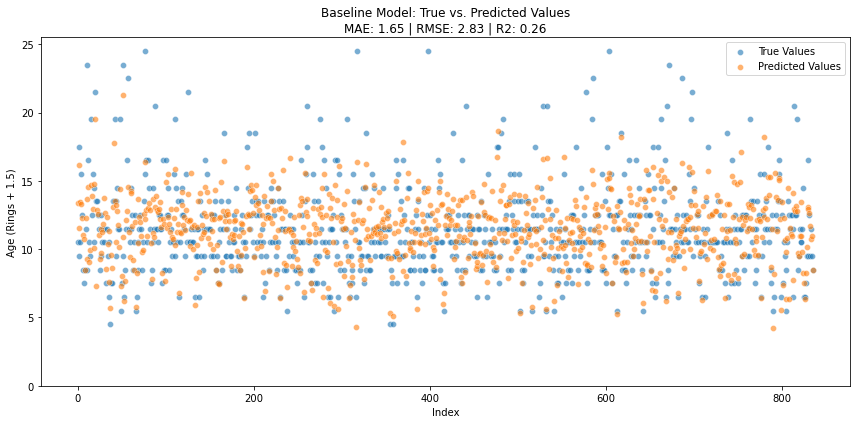

In [16]:
# Plotting predicted vs. true values for the baseline model
plt.figure(figsize=(12, 6))

# True values
sns.scatterplot(x=range(len(y_test)), y=y_test, label="True Values", alpha=0.6)

# Predicted values
sns.scatterplot(x=range(len(y_pred_baseline)), y=y_pred_baseline, label="Predicted Values", alpha=0.6)

plt.title(f"Baseline Model: True vs. Predicted Values\nMAE: {mae_baseline:.2f} | RMSE: {rmse_baseline:.2f} | R2: {r2_baseline:.2f}")
plt.xlabel("Index")
plt.ylim(0, max(y_test.max(), y_pred_baseline.max()) + 1)
plt.ylabel("Age (Rings + 1.5)")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# Define important features based on feature importance for the Random Forest Regressor
important_features = ["Shell weight", "Shucked_to_Whole", "Viscera_to_Whole","Shell_to_Whole", "Volume"]

# Convert the numpy arrays back to DataFrames to extract the important features
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Extract the important features for training and testing
X_train_important = X_train_df[important_features]
X_test_important = X_test_df[important_features]

# Initialize and train the Random Forest model
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train_important, y_train)

# Make predictions on the test set
y_pred_rf = rf_regressor.predict(X_test_important)

# Calculate evaluation metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

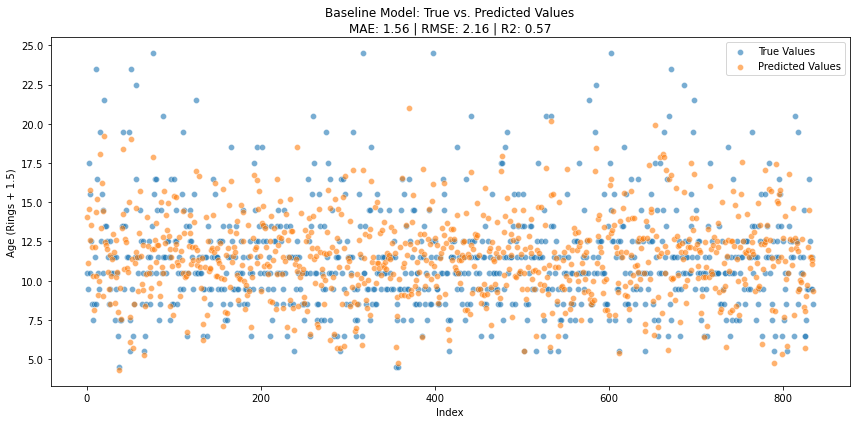

In [18]:
# Plotting predicted vs. true values for the baseline model
plt.figure(figsize=(12, 6))

# True values
sns.scatterplot(x=range(len(y_test)), y=y_test, label="True Values", alpha=0.6)

# Predicted values
sns.scatterplot(x=range(len(y_pred_rf)), y=y_pred_rf, label="Predicted Values", alpha=0.6)

plt.title(f"Baseline Model: True vs. Predicted Values\nMAE: {mae_rf:.2f} | RMSE: {rmse_rf:.2f} | R2: {r2_rf:.2f}")
plt.xlabel("Index")
plt.ylabel("Age (Rings + 1.5)")
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Initialize and train the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(random_state=42)
gb_regressor.fit(X_train_important, y_train)

# Make predictions on the test set
y_pred_gb = gb_regressor.predict(X_test_important)

# Calculate evaluation metrics
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = mean_squared_error(y_test, y_pred_gb, squared=False)
r2_gb = r2_score(y_test, y_pred_gb)

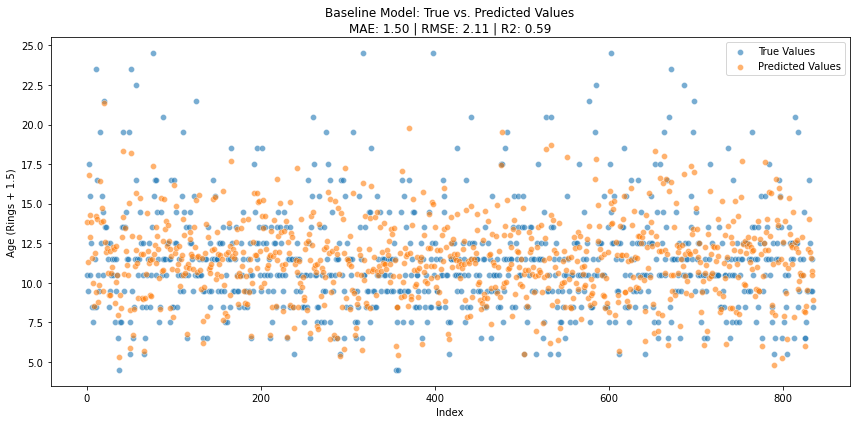

In [20]:
# Plotting predicted vs. true values for the baseline model
plt.figure(figsize=(12, 6))

# True values
sns.scatterplot(x=range(len(y_test)), y=y_test, label="True Values", alpha=0.6)

# Predicted values
sns.scatterplot(x=range(len(y_pred_gb)), y=y_pred_gb, label="Predicted Values", alpha=0.6)

plt.title(f"Baseline Model: True vs. Predicted Values\nMAE: {mae_gb:.2f} | RMSE: {rmse_gb:.2f} | R2: {r2_gb:.2f}")
plt.xlabel("Index")
plt.ylabel("Age (Rings + 1.5)")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# Create a DataFrame to compare the metrics of the three models
model_comparison = pd.DataFrame({
    'Model': ['Baseline (Linear Regression)', 'Random Forest', 'Gradient Boosting'],
    'MAE': [mae_baseline, mae_rf, mae_gb],
    'RMSE': [rmse_baseline, rmse_rf, rmse_gb],
    'R-squared': [r2_baseline, r2_rf, r2_gb]
})

model_comparison

,Model,MAE,RMSE,R-squared
0,Baseline (Linear Regression),1.653438,2.831585,0.259333
1,Random Forest,1.557978,2.156473,0.570413
2,Gradient Boosting,1.504918,2.114136,0.587115


## Baseline (Linear Regression):

This model has the highest error metrics (both MAE and RMSE) and the lowest R-squared value. It explains about 29% of the variance in the age.

## Random Forest:

This model significantly reduces the error metrics compared to the baseline and explains about 57% of the variance in the age.


## Gradient Boosting:
This model has the best performance among the three, with the lowest error metrics and the highest R-squared value. It explains nearly half (59%) of the variance in the age.

## Conclusion:

We found certain features, specifically Shell weight, the ratios of Shucked, Viscera, and Shell weights to Whole weight, and the calculated Volume, to be particularly influential in determining age. Gradient Boosting model achieved an accuracy where, on average, the predicted age deviated by approximately 1.5 years from the true age; this accuracy is commendable and suitable for many applications. However, for tasks requiring pinpoint age determination, further refinement might be needed.